# Instructions
Defining   an      "adopted   user"      as   a   user   who         <b>has   logged   into   the   product   on   three   separate  days   in   at   least   one   seven­day   period  </b>,   <u>identify   which   factors   predict   future   user  adoption  </u>. <br>
Please   send   us   a   brief   writeup   of   your   findings   (the   more   concise,   the   better   ­­   no   more  than   one   page),   along   with   any   summary   tables,   graphs,   code,   or   queries   that   can   help  us   understand   your   approach.   Please   note   any   factors   you   considered   or   investigation  you   did,   even   if   they   did   not   pan   out.   Feel   free   to   identify   any   further   research   or   data  you   think   would   be   valuable.

## 1) Identify adopted users
Let's load the "takehome_user_engagement.csv" file into a Pandas DataFrame and identify the adopted users.

In [4]:
# Import Pandas
import pandas as pd

# Load file into df
df = pd.read_csv("takehome_user_engagement.csv", header=0, index_col=None)

# Display df
print(df)

# Check columns datatype
print(df.info())

                 time_stamp  user_id  visited
0       2014-04-22 03:53:30        1        1
1       2013-11-15 03:45:04        2        1
2       2013-11-29 03:45:04        2        1
3       2013-12-09 03:45:04        2        1
4       2013-12-25 03:45:04        2        1
...                     ...      ...      ...
207912  2013-09-06 06:14:15    11996        1
207913  2013-01-15 18:28:37    11997        1
207914  2014-04-27 12:45:16    11998        1
207915  2012-06-02 11:55:59    11999        1
207916  2014-01-26 08:57:12    12000        1

[207917 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


In [5]:
# As Date operations will be needed, convert time_stamp column from string to Datetime object
# Import datetime
from datetime import datetime, timedelta

# Apply conversion for every element
df.time_stamp = df.time_stamp.apply(lambda x:datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

# Check to see if datatype, for column time_stamp, is datetime
df.info()

# PS: This cell will through an error if executed twice

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [49]:
# DEFINING FUNCTIONS TO MAKE MAIN CODE CLEANER

# Import numpy
import numpy as np


def nextUserID(row, userID):
# When a user is identified as adopted, this function is called to return the next row with a different user.
# This prevents the same user to be added more than once

    if(row == len(df)-1):
        # Last row, just return the row + 1 to exit the while loop in the main code
        
        return row+1
    else:
        # Loop through all rows below the current row and return the row if the user is different than the current userID
        
        for i in np.arange(row+1, len(df)):
            if(df.user_id[i]!=userID):
                return i
    
    # In case the execution gets to this point, it means the last user is an adopted user, we looped through the rest
    # of the list and there was only this user's logins, so the condition df.user_id[i]!=userID was never met. 
    # So I just return len(df) to exit the while loop in the main code
    return len(df)

def dealWith2(row, time):
# Function to deal with list "time" when it has 2 elements  
    
    if(time[1]-time[0]<=delta):
        # The two records are less than or equal to 7 days apart
            
        if(time[0].day == time[1].day):
            # Two logins on the same day. Keep only the second record
                
            time = time[-1]                
            
    else:
        # The two records are more than seven days apart. Keep the second record
            
        time = time[-1]
            
    # return next row
    return row+1


def dealWith3(row, time, userID):
# Function to deal with list "time" when it has 3 elements 
    
    if(time[2] - time[0] <= delta):
        # Fist and third record are less than or equal to 7 days apart
            
        if(time[1].day == time[2].day):
            # ***Tricky part***: CHECK CELLS BELOW to understand why I removed the second element
                
            del time[1]
            
            # Add one to the row
            row+=1    
        
        else:
            # Third record is within 7 days from first record and all three in different days: ADOPTED USER!
            adopted.append(userID)
            
            # Call the function to go to the next user_id
            row = nextUserID(row, userID)
            
    else:
        # Fist and third records are More than or equal to 7 days apart. Remove first record and call dealWith2()       
        time = time[-2:]
        row = dealWith2(row, time)
        
    # return row, which can be the next row or the row of the next user_id
    return row

Code comment: <b>tricky part***</b> (Function dealWith3)<br>
There are two logins in the "time" list and we append a third login to the list. However, the second and third logins are on the same day. One of them needs to be deleted. At first, it seems like it doesn't matter which element we are deleting: they are both on the same day.<br>
However, Timedelta operations take fractions of the day into consideration (hours, minutes...).<br>
To decide which one to eliminate, I thought of the following scenario:
- Login 1: Day 1
- Login 2: Day 3 @12 am
- Login 3: Day 3 @11:59 pm
- Login 4: Day 9
- Login 5: Day 10 @9 am

When execution starts, Login 1 and Login 2 will be appended to the list "time".<br>
The tricky part is reached when Login 3 is read. Login 2 and Login 3 are both on the same day. Should we delete Login 2 or Login 3?<br>
We have 2 scenarios:<br>

<b>Scenario 1</b>: remove <u>Login 2</u> from the list. Then this happens:<br>
- time = [login 1, login 3]
- Login 4 is read. As the distance between login 4 and Login 1 is > 7, we drop login 1.
- But the distance between Login 4 and Login 3 is < 7, so Login 4 is kept
- time = [Login 3, Login 4]
- Login 5 is read. The distance between Login 5 and Login 3 is < 7 --> <b>adopted user!!!</b><br>
    
<b>Scenario 2</b>: remove <u>Login 3</u> from the list. Then this happens:<br>
- time = [login 1, login 2]
- Login 4 is read. As the distance between login 4 and Login 1 is > 7, we drop login 1.
- But the distance between Login 4 and Login 2 is < 7, so Login 4 is kept
- time = [Login 2, Login 4]
- Login 5 is read. The distance between Login 5 and Login 2 is > 7 --> <b>NOT AN ADOPTED USER!!!</b><br>

On the cell below, <b>I mimic those scenarios</b>. I will create dealWith31() (Scenario 1, deletes second Login) and dealWith32() (Scenario 2, deletes third Login), create a list of logins and print the adopted lists to compare.

In [83]:
# TESTING THE CODE FOR EDGE SITUATIONS

logins = [datetime.strptime("2000-01-01","%Y-%m-%d"), datetime.strptime("2000-01-03 00","%Y-%m-%d %H"),
         datetime.strptime("2000-01-03 23:59","%Y-%m-%d %H:%M"), datetime.strptime("2000-01-09","%Y-%m-%d"),
         datetime.strptime("2000-01-10 09","%Y-%m-%d %H")]

def dealWith2_test(row, time):
    if(time[1]-time[0]<=delta):
        if(time[0].day == time[1].day):
            time = time[-1] 
    else:
        time = time[-1]
        
delta = timedelta(days=7)
        
        
# SCENARIO 1  -------------------------------------------------------


def dealWith31(row, time, userID):    
    if(time[2] - time[0] <= delta):
        if(time[1].day == time[2].day):
            # Tricky part***: removed the SECOND element                
            del time[1]
        else:
            adopted_test.append(userID)
    else:  
        del time[0]
        dealWith2(row, time)


adopted_test = []
time_test = []
i = 0    

for i in range(5):
    time_test.append(logins[i])
    if(len(time_test)==2):
        dealWith2_test(i, time_test)
    elif(len(time_test)==3):
        dealWith31(i, time_test, "USER")
    
            
print("Scenario 1: Adopted list - ", adopted_test)  


# SCENARIO 2  -------------------------------------------------------  


def dealWith32(row, time, userID):    
    if(time[2] - time[0] <= delta):
        if(time[1].day == time[2].day):
            # Tricky part***: removed the THIRD element                
            del time[2]
        else:
            adopted_test.append(userID)
    else:
        del time[0]
        dealWith2(row, time)


adopted_test = []
time_test = []
i = 0    

for i in range(5):
    time_test.append(logins[i])
    if(len(time_test)==2):
        dealWith2_test(i, time_test)
    elif(len(time_test)==3):
        dealWith32(i, time_test, "USER")
    
            
print("Scenario 2: Adopted list - ", adopted_test)  

Scenario 1: Adopted list -  ['USER']
Scenario 2: Adopted list -  []


The output above confirms my assumption: Scenario 1 is the correct one, so we need to delete the second Login in that point of the code!<br><br>
Now that the functions are correctly defined, <b>let's write the MAIN CODE to identify the adopted users</b>

In [84]:
# MAIN CODE

# Define a delta of 7 days
delta = timedelta(days=7)

# Empty list to store adopted user's IDs
adopted = []

# Empty list to store timestamps. We are looking for 3 elements less than or equal to 7 days apart, on three different days
time = []

# Initialize row
row = 0

# Initialize userID with the first record of column user_id
userID = df.user_id[0]
    
# While loop. Reminder: number of records = len(df)-1
while(row<len(df)):    
    if(userID != df.user_id[row]):
        # Different user: clear time list and update current user
        
        time = []
        userID = df.user_id[row]
    
    # Add timestamp from the current row to time list
    time.append(df.time_stamp[row])
    
    if(len(time)==2):
        # This is the second timestamp from the same userID. Call function to deal with 2 elements
        
        row = dealWith2(row, time)
            
    elif(len(time)==3):
        # This is the third timestamp from the same userID. Call function to deal with 3 elements
        
        row = dealWith3(row, time, userID)
    else:
        # First element added, just go to next row
        
        row+=1
            
print(adopted)

[20, 53, 69, 141, 197, 202, 247, 311, 418, 478, 509, 591, 627, 632, 634, 724, 728, 754, 937, 985, 1107, 1136, 1155, 1233, 1242, 1319, 1339, 1379, 1410, 1434, 1525, 1592, 1825, 1865, 1897, 1993, 1999, 2009, 2074, 2078, 2080, 2111, 2124, 2278, 2481, 2495, 2544, 2590, 2610, 2618, 2626, 2647, 2724, 2744, 2762, 2857, 2870, 2889, 2979, 3028, 3059, 3076, 3077, 3145, 3179, 3180, 3205, 3222, 3239, 3240, 3280, 3390, 3522, 3541, 3574, 3598, 3623, 3638, 3641, 3652, 3675, 3739, 3765, 3802, 3915, 3957, 4022, 4031, 4093, 4206, 4208, 4216, 4217, 4258, 4266, 4295, 4317, 4396, 4428, 4467, 4513, 4611, 4619, 4824, 4835, 4870, 4884, 4902, 4965, 5101, 5127, 5157, 5180, 5215, 5397, 5467, 5508, 5528, 5560, 5600, 5638, 5663, 5682, 5741, 5832, 5892, 5915, 5939, 5970, 6044, 6050, 6171, 6217, 6239, 6401, 6419, 6462, 6470, 6482, 6597, 6637, 6640, 6653, 6734, 6886, 6909, 6981, 7111, 7156, 7209, 7210, 7327, 7384, 7572, 7590, 7618, 7654, 7682, 7691, 7696, 7707, 7760, 7774, 7786, 7813, 7827, 7858, 7873, 7980, 8025, 80

Now that we have a list of Adopted Users' IDs, let's load the file "takehome_users.csv" into a pandas dataframe and identify them (with a 1 flag) in a new column.<br><br>
PS: pd.read_csv didn't work on file takehome_users.csv, even after trying several encondings. I had to open the file on a notepad, copy it into one column of an excel spreadsheet, split the cells into different columns using coma as a delimiter and saved the file as takehome_user2.csv. The two files are visually equal, with the exact same data, but now the method pd.read_csv works.

In [101]:
# Read file into a Pandas Dataframe
df_users = pd.read_csv("takehome_users2.csv", header=0,  encoding='utf-8')

# Create target colum: 1 = adopted user
df_users["target"] = df_users["object_id"].apply(lambda x:1 if x in adopted else 0)

# Print df_users and columns datatype
print(df_users)
print(df_users.info())

       object_id     creation_time               name  \
0              1   2014-04-22 3:53     Clausen August   
1              2   2013-11-15 3:45      Poole Matthew   
2              3  2013-03-19 23:14  Bottrill Mitchell   
3              4   2013-05-21 8:09    Clausen Nicklas   
4              5  2013-01-17 10:14          Raw Grace   
...          ...               ...                ...   
11995      11996   2013-09-06 6:14       Meier Sophia   
11996      11997  2013-01-10 18:28      Fisher Amelie   
11997      11998  2014-04-27 12:45        Haynes Jake   
11998      11999  2012-05-31 11:55       Faber Annett   
11999      12000   2014-01-26 8:57         Lima Thaís   

                            email     creation_source  \
0        AugustCClausen@yahoo.com        GUEST_INVITE   
1          MatthewPoole@gustr.com          ORG_INVITE   
2      MitchellBottrill@gustr.com          ORG_INVITE   
3       NicklasSClausen@yahoo.com        GUEST_INVITE   
4              GraceRaw@yahoo.

The following actions are needed:
- Confirm the target column is correct
- Columns consideration
- Apply machine learning classification algorithms to identify which variables helps us predict future adopted users

In [103]:
# Confirm target column is correct
assert df_users.target.sum() == len(adopted)

Columns considerations:
- object_id, creation_time, name, email and last_session_creation_time --> drop. Reason: won't help in the predictions
- invited_by_user_id --> create a flag: invited (1) or not(0)?
- org_id --> create a flag based on the size of the group. Users that belong to bigger groups are more likely to adopt?

In [106]:
# Drop colums
toDrop = ["object_id", "creation_time", "name", "email", "last_session_creation_time"]
df_users = df_users.drop(labels=toDrop, axis=1)
df_users

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,target
0,GUEST_INVITE,1,0,11,10803.0,0
1,ORG_INVITE,0,0,1,316.0,0
2,ORG_INVITE,0,0,94,1525.0,0
3,GUEST_INVITE,0,0,1,5151.0,0
4,GUEST_INVITE,0,0,193,5240.0,0
...,...,...,...,...,...,...
11995,ORG_INVITE,0,0,89,8263.0,0
11996,SIGNUP_GOOGLE_AUTH,0,0,200,NaN,0
11997,GUEST_INVITE,1,1,83,8074.0,0
11998,PERSONAL_PROJECTS,0,0,6,NaN,0


In [110]:
# Column invited_by_user_id: create flag
#df_users["invited"] = df_users.invited_by_user_id.apply(lambda x:0 if np.isnan(x) else 1)

# Drop invited_by_user_id
df_users = df_users.drop(labels="invited_by_user_id", axis=1)
df_users

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,target,invited
0,GUEST_INVITE,1,0,11,0,1
1,ORG_INVITE,0,0,1,0,1
2,ORG_INVITE,0,0,94,0,1
3,GUEST_INVITE,0,0,1,0,1
4,GUEST_INVITE,0,0,193,0,1
...,...,...,...,...,...,...
11995,ORG_INVITE,0,0,89,0,1
11996,SIGNUP_GOOGLE_AUTH,0,0,200,0,0
11997,GUEST_INVITE,1,1,83,0,1
11998,PERSONAL_PROJECTS,0,0,6,0,0


Column org_id: considering the following flag:
- 1: users that belong to a group greater than 100 members
- 0: otherwisecount the number of adopted users in each

Let's perform a count of those flags to see if flag 1 has more adopted users than flag 0

In [115]:
# List of org_id where count >= 100
orggt100 = [id for id in df_users.org_id.unique() if list(df_users.org_id).count(id)>100]
orggt100

[1, 0, 2, 7, 6, 4, 5, 10, 3, 9]

In [117]:
# Create column org_gt100
df_users["org_gt100"] = df_users.org_id.apply(lambda x:1 if x in orggt100 else 0)

# Drop column org_id
df_users = df_users.drop(labels="org_id", axis=1)

df_users

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,target,invited,org_gt100
0,GUEST_INVITE,1,0,0,1,0
1,ORG_INVITE,0,0,0,1,1
2,ORG_INVITE,0,0,0,1,0
3,GUEST_INVITE,0,0,0,1,1
4,GUEST_INVITE,0,0,0,1,0
...,...,...,...,...,...,...
11995,ORG_INVITE,0,0,0,1,0
11996,SIGNUP_GOOGLE_AUTH,0,0,0,0,0
11997,GUEST_INVITE,1,1,0,1,0
11998,PERSONAL_PROJECTS,0,0,0,0,1


C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


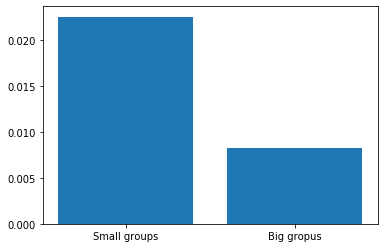

In [129]:
# import library to plot
import matplotlib.pyplot as plt

# Calculate the target rate according to org_gt100
r_gt100_false = len(df_users[df_users.org_gt100==0][df_users.target==1])/len(df_users[df_users.org_gt100==0])
r_gt100_true = len(df_users[df_users.org_gt100==1][df_users.target==1])/len(df_users[df_users.org_gt100==1])

# Plot
plt.bar(["Small groups", "Big gropus"], [r_gt100_false, r_gt100_true])
plt.show()

Contrary to my expectation, smaller groups tend have more adopted users. Maybe big companies subscribe employees by default and only a small percentage of the members actually use the app.<br><br>
Time for the <b>Machin Learning Classification Algorithm</b>. First, let's transform the column "creation_source" into 5 columns, one for each categorie, using the pd.get_dummies() method

In [130]:
df_users = pd.get_dummies(df_users, drop_first=True)
df_users


,opted_in_to_mailing_list,enabled_for_marketing_drip,target,invited,org_gt100,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,0,1,0,0,0,0,0
1,0,0,0,1,1,1,0,0,0
2,0,0,0,1,0,1,0,0,0
3,0,0,0,1,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
11995,0,0,0,1,0,1,0,0,0
11996,0,0,0,0,0,0,0,0,1
11997,1,1,0,1,0,0,0,0,0
11998,0,0,0,0,1,0,1,0,0


Now let's define a function to plot the most important metrics for this type of classification problem, where the classes are imbalanced (way more 1s than 0s)

In [131]:
# PRINT METRICS FUNCTION DEFINITION

# Import necessary Libraries
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Function that prints the relevant data about a classification model
def printMetrics(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print("Total PREDICTED inactive users within 6 months: ",sum(y_pred))
    print("Total ACTUAL inactive users within 6 months: ", sum(y_test))
    print("R Squared: ", accuracy_score(y_test, y_pred))
    print("F1Score: ", f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:")
    print(cm)
    print("Recall: ", cm[1,1]/(cm[1,0]+cm[1,1]))

Now we need to split into train and test datasets, so we can verify the accuracy of out model

In [133]:
# SPLIT INTO TRAIN / TEST DATASETS AND DUMMY COLUMNS

# Import necessary Libraries
from sklearn.model_selection import train_test_split

# Isolate the target column
y = df_users.target

# Drop the target column and store in a copy of the dataFrame df.
df_copy = df_users.drop(labels="target", axis=1)

# Split the data: 30% / 70%, full dataset (note the stratify parameter, as the classes are imbalanced)
X_train, X_test, y_train, y_test = train_test_split(df_copy, y, test_size=0.30, random_state=0, stratify=y, shuffle=True)

We need a benchmark. Let's use the dummy classifier from sklearn

In [134]:
# DEFINING BENCHMARK - DUMMY CLASSIFIER

# Import necessary Libraries
from sklearn.dummy import DummyClassifier

# Define and fit dummy classifier
dummy_clf = DummyClassifier(random_state=0).fit(X_train, y_train)

# Print relevant metrics using the full dataset
printMetrics(dummy_clf, X_test, y_test)

Total PREDICTED inactive users within 6 months:  76
Total ACTUAL inactive users within 6 months:  74
R Squared:  0.96
F1Score:  0.04
Confusion matrix:
[[3453   73]
 [  71    3]]
Recall:  0.04054054054054054


Let's try Logistic Regression, Stochasti Gradient Descent and Gradient Boosting Classifier

In [135]:
# LOGISTIC REGRESSION

# Import LogisticRegression model
from sklearn.linear_model import LogisticRegression

# Train model with full dataset
clf = LogisticRegression(random_state=5, solver= 'lbfgs', max_iter=300).fit(X_train, y_train)

# Print relevant metrics
printMetrics(clf,X_test, y_test)

Total PREDICTED inactive users within 6 months:  0
Total ACTUAL inactive users within 6 months:  74
R Squared:  0.9794444444444445
F1Score:  0.0
Confusion matrix:
[[3526    0]
 [  74    0]]
Recall:  0.0


C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [138]:
# STOCHASTIC GRADIENT DESCENT

# Import SGD classifier, along with StandardScaler and make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Train the model with the full dataset. Notice the parameter Class_weight, to consider imbalanced dataset.
# It is highly indicated to use Standard Scaler with this model. A pipeline is required
clf = make_pipeline(StandardScaler(), SGDClassifier(class_weight='balanced', random_state=42)).fit(X_train, y_train)
printMetrics(clf, X_test, y_test)

Total PREDICTED inactive users within 6 months:  0
Total ACTUAL inactive users within 6 months:  74
R Squared:  0.9794444444444445
F1Score:  0.0
Confusion matrix:
[[3526    0]
 [  74    0]]
Recall:  0.0


C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
# GRADIENT BOOSTING CLASSIFIER

# Import Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Train model - full dataset
clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

# Print metrics
printMetrics(clf, X_test, y_test)

Total PREDICTED inactive users within 6 months:  0
Total ACTUAL inactive users within 6 months:  74
R Squared:  0.9794444444444445
F1Score:  0.0
Confusion matrix:
[[3526    0]
 [  74    0]]
Recall:  0.0


C:\Users\Rafael\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


As we may see, all models failed to make any adopted user prediction. I am giving up on trying to find a classification model and will plot the correlation between the variables to see if I can at least give suggestions. To do so, I'll use the seaborn library

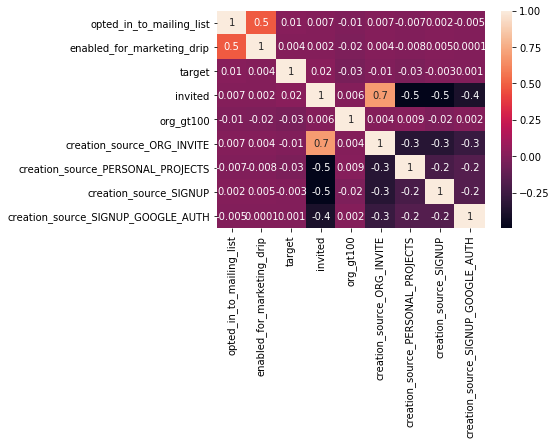

In [140]:
# Import seaborn library
import seaborn as sns

# Build heatmap
sns.heatmap(df_users.corr(), annot = True, fmt='.1g')

# Show plot
plt.show()

As expected, the correlations to the target column are very low. Not a surprise that no model was able to make a prediction.
## Conclusion
Writing the code to identify adopted users was quite challenging, specially when treating edge cases. However, as far as identifying the factors that are more relevant to future predictions, this project failed.